# Exploring the Effects of Different Degraders on Estimated Redshifts

**Authors:** Jennifer Scora

**Last run successfully:** Feb 4, 2025

In this notebook, we'll explore how to create simulated datasets with the [RAIL creation stage](https://descraildocs.z27.web.core.windows.net/source/rail_stages/creation.html), in particular focusing on how data sets created using different degradation algorithms can affect the training of models to estimate photometric redshifts (photo-zs). Here "degradation" algorithms refer to any algorithms applied to alter the "true" sample, for example to add biases or cuts. 

Here are the main steps we'll be following:

1. **Create the "true" data sets:** use an engine to sample tests and training data sets 
2. **Create "degraded" data sets:** 
    create multiple training data sets with different degradation algorithms, and one test data set with all the degradation algorithms used 
3. **Use the data sets to estimate redshifts:** 
    use the training data sets to train different models, and use each model on the same test data set  
4. **Evaluate the estimated redshift distributions and compare them:** 
    use the evaluator stages to calculate metrics for each model, and assess how certain degraders affect the resulting distributions

## 1. Create the "true" data sets

### Set up

Let's start by importing the packages we'll need to create the data sets.

In [1]:
import rail.interactive as ri 
import numpy as np
import tables_io
from pzflow.examples import get_galaxy_data

# for plotting 
import matplotlib.pyplot as plt
%matplotlib inline

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


LEPHAREDIR is being set to the default cache directory:
/home/jscora/.cache/lephare/data
More than 1Gb may be written there.
LEPHAREWORK is being set to the default cache directory:
/home/jscora/.cache/lephare/work
Default work cache is already linked. 
This is linked to the run directory:
/home/jscora/.cache/lephare/runs/20250327T165906


We need to set up some column name dictionaries, as the expected column names vary between some of the codes. In order to handle this, we can pass in  dictionaries of expected column names and the column name that exists in the input data (`band_dict` and `rename_dict` below). In this notebook, we are using bands ugrizy, and each band will have a name 'mag_u_lsst', for example, with the error column name being 'mag_err_u_lsst'.

In [2]:
bands = ["u", "g", "r", "i", "z", "y"]
band_dict = {band: f"mag_{band}_lsst" for band in bands}
rename_dict = {f"mag_{band}_lsst_err": f"mag_err_{band}_lsst" for band in bands}

Now we can grab the galaxy data we'll use to train our creation model, and we'll rename the band columns to match our desired band names as discussed above, using `band_dict`. We can check that our columns have been renamed appropriately by printing out the first few lines of the table.

In [3]:
catalog = get_galaxy_data().rename(band_dict, axis=1)
# let's take a look at the columns
catalog.head()

,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,0.287087,26.759261,25.901778,25.187710,24.932318,24.736903,24.671623
1,0.293313,27.428358,26.679299,25.977161,25.700094,25.522763,25.417632
2,1.497276,27.294001,26.068798,25.450055,24.460507,23.887221,23.206112
3,0.283310,28.154075,26.283166,24.599570,23.723491,23.214108,22.860012
4,1.545183,29.276065,27.878301,27.333528,26.543374,26.061941,25.383056


Looks like the column names are the way we want them! 

### Train and sample the model

Now we need to use the galaxy data we retrieved to train the model that we'll use to create our input galaxy magnitude data catalogues later. We're going to use the `PZflow` engine to do this, specifically the `modeler` function. This will train the normalizing flow that serves as the engine for the input data creation. To get a sense of what it does and the parameters it needs, let's check out its docstrings:

In [4]:
ri.creation.engines.flowEngine.flow_modeler?

Signature:       ri.creation.engines.flowEngine.flow_modeler(**kwargs) -> Any
Call signature:  ri.creation.engines.flowEngine.flow_modeler(*args, **kwargs)
Type:            partial
String form:     functools.partial(<function _interactive_factory at 0x725bf30c4c20>, <class 'rail.creation.engines.flowEngine.FlowModeler'>, False, True)
File:            ~/software/anaconda3/envs/rail/lib/python3.12/functools.py
Docstring:      
Modeler wrapper for a PZFlow Flow object.

This class trains the flow.

---

Produce a creation model from which photometry and redshifts can be
generated.

---

This function was generated from the function
rail.creation.engines.flowEngine.FlowModeler.fit_model

Parameters
----------
input : DataHandle
    ???
seed : int, optional
    The random seed for training.
    Default: 0
phys_cols : dict, optional
    Names of non-photometry columns and their corresponding [min, max] values.
    Default: {'redshift': [0, 3]}
phot_cols : dict, optional
    Names of photomet

We'll pass the modeler a few parameters:
- **input:** this is the input catalog that our modeler needs to train the data flow (the one we retrieved above)
- **seed (optional):** this is the random seed used for training
- **phys_cols (optional):** The names of any non-photometry columns and their [min,max] values.
- **phot_cols (optional):** This is a dictionary of the names of the photometry columns and their corresponding [min,max] values.
- **calc_colors (optional):** Whether to internally calculate colors (if phot_cols are magnitudes). Assumes that you want to calculate colors from adjacent columns in phot_cols. If you do not want to calculate colors, set False. Else, provide a dictionary `{‘ref_column_name’: band}`, where band is a string corresponding to the column in phot_cols you want to save as the overall galaxy magnitude. We're passing in the default value here just so you can see how it works. 

In [5]:
flow_model = ri.creation.engines.flowEngine.flow_modeler(
    input=catalog,
    seed=0,
    phys_cols={"redshift": [0, 3]},
    phot_cols={
        "mag_u_lsst": [17, 35],
        "mag_g_lsst": [16, 32],
        "mag_r_lsst": [15, 30],
        "mag_i_lsst": [15, 30],
        "mag_z_lsst": [14, 29],
        "mag_y_lsst": [14, 28],
    },
    calc_colors={"ref_column_name": "mag_i_lsst"},
)

Inserting handle into data store.  input: None, FlowModeler
Training 30 epochs 
Loss:
(0) 21.3266
(1) 3.9686
(2) 1.9351
(3) 5.2006
(4) -0.3579
(5) 2.2561
(6) 1.5917
(7) 0.3691
(8) -1.0218
(9) inf
Training stopping after epoch 9 because training loss diverged.
Inserting handle into data store.  model: inprogress_model.pkl, FlowModeler


Now we'll use the flow to produce some synthetic data for our training data set and test data set. We'll create datasets with 600 galaxies for this sample, so we'll pass in the argument: `n_samples = 600`. We'll also use a specific seed for each one to ensure they're reproducible but different from each other.

**Note that when we pass the model to this function, we don't pass the dictionary, but the actual model object. This is true of all the interactive functions.** 

In [6]:
# get sample test and training data sets
train_data_orig = ri.creation.engines.flowEngine.flow_creator(
    n_samples=600, model=flow_model["model"], seed=1235
)
test_data_orig = ri.creation.engines.flowEngine.flow_creator(
    model=flow_model["model"], n_samples=600, seed=1234
)

Inserting handle into data store.  model: <pzflow.flow.Flow object at 0x725af43e3c50>, FlowCreator
Inserting handle into data store.  output: inprogress_output.pq, FlowCreator
Inserting handle into data store.  model: <pzflow.flow.Flow object at 0x725af43e3c50>, FlowCreator
Inserting handle into data store.  output: inprogress_output.pq, FlowCreator


## 2. Create "degraded" data sets by applying different sets of degraders

Let's make 4 different training data sets using increasingly more degraders, and one set of test data with all four degradations applied. The degraders we'll be using are:

1. `lsst_error_model` to add photometric errors that are modelled based on the telescope
2. `inv_redshift_incompleteness` to mimic redshift dependent incompleteness
3. `line_confusion` to simulate the effect of misidentified lines 
4. `quantity_cut` mimics a band-dependent brightness cut


### 1. LSST Error Model

This method adds photometric errors, non-detections and extended source errors that are modelled based on the Vera Rubin telescope. We're going to apply it to both training and test data sets. Once again, we're supplying different seeds to ensure the results are reproducible and different from each other. We need to supply the `band_dict` we created earlier, which tells the code what the band column names should be. We are also supplying `ndFlag=np.nan`, which just tells the code to make non-detections `np.nan` in the output. 

In [7]:
train_data_photerrs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=train_data_orig["output"], seed=66, renameDict=band_dict, ndFlag=np.nan
)

Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LSSTErrorModel


In [8]:
# let's see what the output looks like 
train_data_photerrs["output"].head()

,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,0.081514,21.600708,0.007486,20.599435,0.005083,19.996831,0.005023,19.694191,0.005033,19.587435,0.005082,19.553563,0.005326
1,1.982106,28.045543,1.087031,27.984741,0.463765,27.825487,0.367745,27.414988,0.410799,26.406834,0.331409,25.950067,0.473291
2,0.741412,24.239717,0.055593,24.456792,0.023063,24.182278,0.016138,23.614150,0.015944,23.513933,0.027296,23.499913,0.060768
3,0.873177,24.227208,0.054985,24.026876,0.016102,23.444153,0.009345,22.679293,0.008227,21.333696,0.006288,21.014948,0.008182
4,0.534689,24.932885,0.102129,24.096806,0.017046,23.026369,0.007389,22.655102,0.008117,22.539690,0.012207,22.390550,0.022870


You can see that the error columns have been added in for each of the magnitude columns. 

Now let's take a look at what's happened to the magnitudes. Below we'll plot the u-band magnitudes before and after running the degrader. You can see that the higher magnitude objects now have a much wider variance in magnitude compared to their initial magnitudes, but at lower magnitudes they've remained similar:

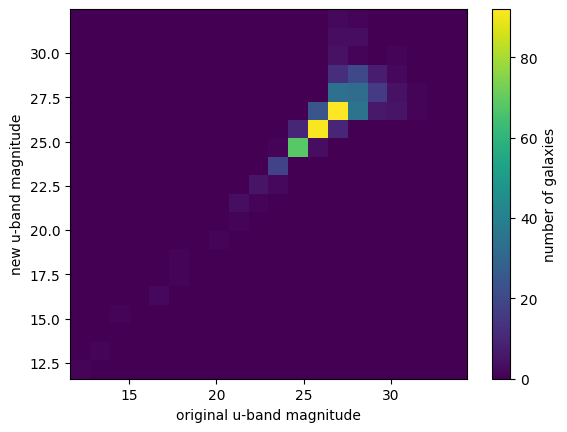

In [9]:
# we have to set the range because there are nans in the new dataset with errors, which messes up plt.hist2d 
range = [[np.min(train_data_orig["output"]["mag_u_lsst"]),np.max(train_data_orig["output"]["mag_u_lsst"])],
         [np.min(train_data_photerrs["output"]["mag_u_lsst"]),np.max(train_data_photerrs["output"]["mag_u_lsst"])]]
plt.hist2d(train_data_orig["output"]["mag_u_lsst"], train_data_photerrs["output"]["mag_u_lsst"], range=range, bins=20,cmap="viridis")
plt.xlabel("original u-band magnitude")
plt.ylabel("new u-band magnitude")
plt.colorbar(label="number of galaxies")

You can make this plot for all the other magnitudes if you'd like. 

### 2. Redshift Incompleteness 

This method applies a selection function, which keeps galaxies with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, where $z_p$ is the ''pivot'' redshift. We'll use $z_p = 1.0$. 

**NOTE**:
This means that the output of the stage will have fewer galaxies than the input. We want to ensure that our degraded test data set matches our original "true" data set, so that the evaluation will be able to directly compare them. To do this, we can use the parameter `drop_rows=False`. This will return a data object of the same length as before, with a "flag" column that identifies which galaxies are to be kept, and which are to be dropped. 

**[NEEDS EDITING]** 
If we instead want to ensure that our sample remains the same size -- which will be important later for evaluating the results, since we need to have the true redshift and the estimated redshift to compare -- we can pass in `drop_rows=False` to the degrader. We'll do this for our test data sample, so we can use this degrader but keep the same number of samples. 

In [16]:
train_data_inc = ri.creation.degraders.spectroscopic_degraders.inv_redshift_incompleteness(input=train_data_photerrs["output"], pivot_redshift=1.0, drop_rows=False)
train_data_inc["output"] # look at the output 

Inserting handle into data store.  input: None, InvRedshiftIncompleteness
Inserting handle into data store.  output: inprogress_output.pq, InvRedshiftIncompleteness


,flag,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,True,0.081514,21.600708,0.007486,20.599435,0.005083,19.996831,0.005023,19.694191,0.005033,19.587435,0.005082,19.553563,0.005326
1,True,1.982106,28.045543,1.087031,27.984741,0.463765,27.825487,0.367745,27.414988,0.410799,26.406834,0.331409,25.950067,0.473291
2,True,0.741412,24.239717,0.055593,24.456792,0.023063,24.182278,0.016138,23.614150,0.015944,23.513933,0.027296,23.499913,0.060768
3,True,0.873177,24.227208,0.054985,24.026876,0.016102,23.444153,0.009345,22.679293,0.008227,21.333696,0.006288,21.014948,0.008182
4,True,0.534689,24.932885,0.102129,24.096806,0.017046,23.026369,0.007389,22.655102,0.008117,22.539690,0.012207,22.390550,0.022870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,True,1.827520,NaN,NaN,28.564051,0.701622,27.568611,0.299993,27.098209,0.320652,25.417800,0.145805,26.236930,0.583466
596,True,0.789594,26.969790,0.536834,27.603759,0.345976,27.147304,0.212318,26.528591,0.201047,26.007307,0.239788,26.194979,0.566227
597,True,1.055365,26.709837,0.442794,26.679047,0.161480,25.869220,0.070238,25.364239,0.073322,24.475552,0.063882,24.367767,0.130250
598,True,0.579771,26.136466,0.282555,26.214452,0.108109,25.535501,0.052243,25.233874,0.065329,25.139298,0.114569,24.849029,0.196470


In [17]:
inc_flag = train_data_inc["output"]["flag"]

In [18]:
train_data_inc["output"].drop(columns="flag",inplace=True) # mask the data down to cut out the lines that are cut out by the degrader 
new_train_data_inc = train_data_inc["output"].where(inc_flag, np.nan)

In [23]:
new_train_data_inc

,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,0.081514,21.600708,0.007486,20.599435,0.005083,19.996831,0.005023,19.694191,0.005033,19.587435,0.005082,19.553563,0.005326
1,1.982106,28.045543,1.087031,27.984741,0.463765,27.825487,0.367745,27.414988,0.410799,26.406834,0.331409,25.950067,0.473291
2,0.741412,24.239717,0.055593,24.456792,0.023063,24.182278,0.016138,23.614150,0.015944,23.513933,0.027296,23.499913,0.060768
3,0.873177,24.227208,0.054985,24.026876,0.016102,23.444153,0.009345,22.679293,0.008227,21.333696,0.006288,21.014948,0.008182
4,0.534689,24.932885,0.102129,24.096806,0.017046,23.026369,0.007389,22.655102,0.008117,22.539690,0.012207,22.390550,0.022870
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1.827520,NaN,NaN,28.564051,0.701622,27.568611,0.299993,27.098209,0.320652,25.417800,0.145805,26.236930,0.583466
596,0.789594,26.969790,0.536834,27.603759,0.345976,27.147304,0.212318,26.528591,0.201047,26.007307,0.239788,26.194979,0.566227
597,1.055365,26.709837,0.442794,26.679047,0.161480,25.869220,0.070238,25.364239,0.073322,24.475552,0.063882,24.367767,0.130250
598,0.579771,26.136466,0.282555,26.214452,0.108109,25.535501,0.052243,25.233874,0.065329,25.139298,0.114569,24.849029,0.196470


In [ ]:
train_test_output = train_data_inc["output"][train_data_inc["output"]["flag"]].drop("flag", axis=1)

KeyError: "['flag'] not found in axis"

In [ ]:
train_test_output.info()

In [ ]:
# renames error columns to match DC2
train_data_inc_col = ri.tools.table_tools.column_mapper(
    input=new_train_data_inc["output"], columns=rename_dict
)

In [15]:
# dataset 3: add in line confusion
train_data_conf = ri.creation.degraders.spectroscopic_degraders.line_confusion(
    input=train_data_inc["output"],
    true_wavelen=5007.0,
    wrong_wavelen=3727.0,
    frac_wrong=0.05,
    seed=1337,
)
# renames error columns to match DC2
train_data_conf_col = ri.tools.table_tools.column_mapper(
    input=train_data_conf["output"], columns=rename_dict
)

train_data_conf

Inserting handle into data store.  input: None, LineConfusion
Inserting handle into data store.  output: inprogress_output.pq, LineConfusion
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper


{'output':      redshift  mag_u_lsst  mag_u_lsst_err  mag_g_lsst  mag_g_lsst_err  \
 0    0.081514   21.600708        0.007486   20.599435        0.005083   
 1    0.741412   24.239717        0.055593   24.456792        0.023063   
 2    0.873177   24.227208        0.054985   24.026876        0.016102   
 3    1.061763   24.932885        0.102129   24.096806        0.017046   
 4    0.694544   26.548970        0.391600   25.830116        0.077157   
 ..        ...         ...             ...         ...             ...   
 502  1.827520         NaN             NaN   28.564051        0.701622   
 503  0.789594   26.969790        0.536834   27.603759        0.345976   
 504  1.761260   26.709837        0.442794   26.679047        0.161480   
 505  0.579771   26.136466        0.282555   26.214452        0.108109   
 506  0.296046   30.977062        3.562510   26.568271        0.146869   
 
      mag_r_lsst  mag_r_lsst_err  mag_i_lsst  mag_i_lsst_err  mag_z_lsst  \
 0     19.996831        

In [36]:
# cut some of the data below a certain magnitude 
train_data_cut = ri.creation.degraders.quantityCut.quantity_cut(
    input=new_train_data_inc, cuts={"mag_i_lsst": 25.0}, drop_rows=False
)
train_data_cut["output"]

Inserting handle into data store.  input: None, QuantityCut
Inserting handle into data store.  output: inprogress_output.pq, QuantityCut


,flag,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,1,0.081514,21.600708,0.007486,20.599435,0.005083,19.996831,0.005023,19.694191,0.005033,19.587435,0.005082,19.553563,0.005326
1,0,1.982106,28.045543,1.087031,27.984741,0.463765,27.825487,0.367745,27.414988,0.410799,26.406834,0.331409,25.950067,0.473291
2,1,0.741412,24.239717,0.055593,24.456792,0.023063,24.182278,0.016138,23.614150,0.015944,23.513933,0.027296,23.499913,0.060768
3,1,0.873177,24.227208,0.054985,24.026876,0.016102,23.444153,0.009345,22.679293,0.008227,21.333696,0.006288,21.014948,0.008182
4,1,0.534689,24.932885,0.102129,24.096806,0.017046,23.026369,0.007389,22.655102,0.008117,22.539690,0.012207,22.390550,0.022870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,1.827520,NaN,NaN,28.564051,0.701622,27.568611,0.299993,27.098209,0.320652,25.417800,0.145805,26.236930,0.583466
596,0,0.789594,26.969790,0.536834,27.603759,0.345976,27.147304,0.212318,26.528591,0.201047,26.007307,0.239788,26.194979,0.566227
597,0,1.055365,26.709837,0.442794,26.679047,0.161480,25.869220,0.070238,25.364239,0.073322,24.475552,0.063882,24.367767,0.130250
598,0,0.579771,26.136466,0.282555,26.214452,0.108109,25.535501,0.052243,25.233874,0.065329,25.139298,0.114569,24.849029,0.196470


In [37]:
cut_flag = train_data_cut["output"]["flag"]

In [38]:
train_data_cut["output"].drop(columns="flag",inplace=True) # mask the data down to cut out the lines that are cut out by the degrader 
new_train_data_cut = train_data_cut["output"].where(cut_flag == 1, np.nan)
new_train_data_cut

,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,0.081514,21.600708,0.007486,20.599435,0.005083,19.996831,0.005023,19.694191,0.005033,19.587435,0.005082,19.553563,0.005326
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.741412,24.239717,0.055593,24.456792,0.023063,24.182278,0.016138,23.614150,0.015944,23.513933,0.027296,23.499913,0.060768
3,0.873177,24.227208,0.054985,24.026876,0.016102,23.444153,0.009345,22.679293,0.008227,21.333696,0.006288,21.014948,0.008182
4,0.534689,24.932885,0.102129,24.096806,0.017046,23.026369,0.007389,22.655102,0.008117,22.539690,0.012207,22.390550,0.022870
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# renames error columns to match DC2
train_data_cut_col = ri.tools.table_tools.column_mapper(
    input=new_train_data_cut, columns=rename_dict
)

train_data_photerrs_col = ri.tools.table_tools.column_mapper(
    input=train_data_photerrs["output"], columns=rename_dict
)

Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper


In [ ]:
### create three different training data sets
n_final = 400

# dataset 1: just photometric errors 
train_data_photerrs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=train_data_orig["output"], seed=66, renameDict=band_dict, ndFlag=np.nan
)
# renames error columns to match DC2
train_data_photerrs_col = ri.tools.table_tools.column_mapper(
    input=train_data_photerrs["output"], columns=rename_dict
)
#converts output to a numpy dictionary
train_data = ri.tools.table_tools.table_converter(
    input=train_data_photerrs_col["output"], output_format="numpyDict"
)
df_train_photerrs = tables_io.convertObj(train_data_photerrs_col["output"], tables_io.types.PD_DATAFRAME)


# dataset 2: add in redshift incompleteness 
train_data_inc = (
    ri.creation.degraders.spectroscopic_degraders.inv_redshift_incompleteness(
        input=train_data_photerrs["output"], pivot_redshift=1.0
    )
)
# renames error columns to match DC2
train_data_inc_col = ri.tools.table_tools.column_mapper(
    input=train_data_inc["output"], columns=rename_dict
)
df_train_inc = tables_io.convertObj(train_data_inc_col["output"], tables_io.types.PD_DATAFRAME)


# dataset 3: add in line confusion
train_data_conf = ri.creation.degraders.spectroscopic_degraders.line_confusion(
    input=train_data_inc["output"],
    true_wavelen=5007.0,
    wrong_wavelen=3727.0,
    frac_wrong=0.05,
    seed=1337,
)
# renames error columns to match DC2
train_data_conf_col = ri.tools.table_tools.column_mapper(
    input=train_data_conf["output"], columns=rename_dict
)
df_train_conf = tables_io.convertObj(train_data_conf_col["output"], tables_io.types.PD_DATAFRAME)


# cut all the dataframes down to be an equal size
df_train_photerrs = df_train_photerrs.iloc[:n_final]
df_train_inc = df_train_inc.iloc[:n_final]
df_train_conf = df_train_conf.iloc[:n_final]


In [43]:
### degrade test data
# add photometric errors modelled on LSST to the data
test_data_errs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=test_data_orig["output"], seed=66, renameDict=band_dict, ndFlag=np.nan
)
# randomly removes some galaxies above certain redshift threshold 
# test_data_inc = (
#     ri.creation.degraders.spectroscopic_degraders.inv_redshift_incompleteness(
#         input=test_data_errs["output"], pivot_redshift=1.0, drop_rows=False
#     )
# )
# simulates the effect of misidentified lines 
test_data_conf = ri.creation.degraders.spectroscopic_degraders.line_confusion(
    input=test_data_errs["output"],
    true_wavelen=5007.0,
    wrong_wavelen=3727.0,
    frac_wrong=0.05,
    seed=1337,
)
# # cut some of the data below a certain magnitude 
# test_data_cut = ri.creation.degraders.quantityCut.quantity_cut(
#     input=test_data_conf["output"], cuts={"mag_i_lsst": 25.0}
# )
# renames error columns to match DC2
test_data_pq = ri.tools.table_tools.column_mapper(
    input=test_data_conf["output"], columns=rename_dict
)

df_test_data = tables_io.convertObj(test_data_pq["output"], tables_io.types.PD_DATAFRAME)


# # converts output to a numpy dictionary
# train_data = ri.tools.table_tools.table_converter(
#     input=train_data_pq["output"], output_format="numpyDict"
# )

Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LSSTErrorModel
Inserting handle into data store.  input: None, LineConfusion
Inserting handle into data store.  output: inprogress_output.pq, LineConfusion
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper


### Plot the different datasets 

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline

hist_options = {
    "histtype": "step",
    "bins":30,
    "range": (0,3)
}

plt.hist(df_train_photerrs["redshift"],label="Truth",**hist_options)
plt.hist(df_train_inc["redshift"], label="Redshift incompleteness",**hist_options)
plt.hist(df_train_conf["redshift"], label="Line Confusion",**hist_options)
plt.xlabel("Redshift")
plt.ylabel("Galaxy density")
plt.legend(loc="best")

In [ ]:
# train the model
inform_bpz = ri.estimation.algos.bpz_lite.bpz_lite_informer(
    input=train_data, nondetect_val=np.nan, model="bpz.pkl", hdf5_groupname=""
)
# estimate the photozs 
bpz_estimated = ri.estimation.algos.bpz_lite.bpz_lite_estimator(
input=df_test_data,
model=inform_bpz["model"],
nondetect_val=np.nan,
hdf5_groupname="",
)

bpz_estimated

In [ ]:
df_train_photerrs

## Estimate

In [44]:
# train_datasets = [df_train_photerrs, df_train_inc, df_train_conf]
train_datasets = [train_data_cut_col]
point_est_list = []
eval_list = []

for df in train_datasets:

    # train the model
    inform_bpz = ri.estimation.algos.bpz_lite.bpz_lite_informer(
        input=df, nondetect_val=np.nan, model="bpz.pkl", hdf5_groupname=""
    )
    # estimate the photozs 
    bpz_estimated = ri.estimation.algos.bpz_lite.bpz_lite_estimator(
    input=df_test_data,
    model=inform_bpz["model"],
    nondetect_val=np.nan,
    hdf5_groupname="",
    )

    # summarize the distributions
    point_estimate_ens = ri.estimation.algos.point_est_hist.point_est_hist_summarizer(
    input=bpz_estimated["output"]
    )
    point_est_list.append(point_estimate_ens)

    # evaluate the results 
    evaluator_stage_dict = dict(
        metrics=["cdeloss", "brier"],
        _random_state=None,
        metric_config={
            "brier": {"limits": (0, 3.1)},
        },
    )
    the_eval = ri.evaluation.dist_to_point_evaluator.dist_to_point_evaluator(
            input={"data": bpz_estimated["output"], "truth": test_data_orig["output"]
            },
            **evaluator_stage_dict,
            hdf5_groupname="",
        )
    
    # put the evaluation results in a dictionary so we have them 
    eval_list.append(the_eval)


Inserting handle into data store.  input: None, BPZliteInformer
Inserting handle into data store.  model: inprogress_bpz.pkl, BPZliteInformer
Inserting handle into data store.  input: None, BPZliteEstimator
Inserting handle into data store.  model: {'fo_arr': array([0.35, 0.5 ]), 'kt_arr': array([0.45 , 0.147]), 'zo_arr': array([0.431 , 0.39  , 0.0626]), 'km_arr': array([0.0913, 0.0636, 0.123 ]), 'a_arr': array([2.465, 1.806, 0.906]), 'mo': 20.0, 'nt_array': [1, 2, 5]}, BPZliteEstimator
Process 0 running estimator on chunk 0 - 600


Inserting handle into data store.  output: inprogress_output.hdf5, BPZliteEstimator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 600
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator


In [45]:
eval_list[0]

{'output': {},
 'summary': {'cdeloss': array([-0.60694335]), 'brier': array([232.94858283])},
 'single_distribution_summary': {}}